# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb`. The version available here https://github.com/fchollet/deep-learning-with-python-notebooks does not work with TensorFlow 2. Use the implementation available here: https://github.com/pnugues/edan95/tree/master/labs instead.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [3]:
import os
import random
import shutil
from tqdm import tqdm
# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [4]:
# # Here write the path to your dataset
# if machine_name == 'colab': # If you run your notebook with colab
#   base = '/content/drive/My Drive/Applied machine learning'
base = '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN'

In [5]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['dandelion', 'daisy', 'tulip', 'sunflower', 'rose']


['/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN/flowers/dandelion',
 '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN/flowers/daisy',
 '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN/flowers/tulip',
 '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN/flowers/sunflower',
 '/home/nabil/Bureau/3A/courses/machine_learning/lab/lab2020/CNN/flowers/rose']

We build the (image, label) pairs

In [6]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('14728922673_99086a3818_n.jpg', 'dandelion'),
 ('31530587330_ba31bd196e_n.jpg', 'dandelion'),
 ('3539077354_c67aa7168d_m.jpg', 'dandelion'),
 ('13881700933_69a750d418_n.jpg', 'dandelion'),
 ('12093962485_7c3e9a2a23_n.jpg', 'dandelion'),
 ('2387025546_6aecb1b984_n.jpg', 'dandelion'),
 ('34694292346_83b4d97809_n.jpg', 'dandelion'),
 ('5675705011_82729927ca_n.jpg', 'dandelion'),
 ('4558536575_d43a611bd4_n.jpg', 'dandelion'),
 ('4258272381_65bd4b8191_m.jpg', 'dandelion')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [7]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [8]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

In [161]:
# The target shape
import cv2
dim = (0, 0)
for i in range(0,50):  
    img_path = pairs[i][0]
    color = pairs[i][1]
    im = os.path.join(original_dataset_dir, color, img_path)
#     print(im)
    img = cv2.imread(im)
    dimensions = img.shape
    dim = (dim[0] + dimensions[0], dim[1] + dimensions[1])
dim = (dim[0]//50, dim[1]//50)
dimension = dim
dimensions = (dim[0], dim[1], 3)

dimension = (150, 150)
dimensions = (150, 150, 3)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

Using TensorFlow backend.


In [11]:
# Data preprocessing
train_path = os.path.join(dataset, 'train')
test_path = os.path.join(dataset, 'test')
val_path = os.path.join(dataset, 'validation')

Create the network and compile it

In [12]:
classifier = models.Sequential()
classifier.add(layers.Conv2D(filters = 32, kernel_size = 3, input_shape = dimensions))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 64, kernel_size = 3 , activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 128, kernel_size = 3, activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Conv2D(filters = 128, kernel_size = 3, activation='relu'))
classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(units = 512, activation='relu'))
classifier.add(layers.Dense(units = 5, activation='softmax'))
classifier.compile(optimizer = OPTIMIZER,
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

Create now the data generators for the training, validation, and test set

In [13]:
# normalizing and scaling data
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size = 20,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = 20,
        shuffle=False,
        class_mode="categorical")


Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [14]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size

And fit your model

In [15]:
history = classifier.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Epoch 1/30
129/129 [==============================] - 14s 111ms/step - loss: 1.9670 - accuracy: 0.3911 - val_loss: 1.2460 - val_accuracy: 0.5186
Epoch 2/30
129/129 [==============================] - 12s 91ms/step - loss: 1.1048 - accuracy: 0.5740 - val_loss: 0.7931 - val_accuracy: 0.6097
Epoch 3/30
129/129 [==============================] - 12s 90ms/step - loss: 0.9188 - accuracy: 0.6575 - val_loss: 0.8455 - val_accuracy: 0.6441
Epoch 4/30
129/129 [==============================] - 12s 90ms/step - loss: 0.7292 - accuracy: 0.7363 - val_loss: 1.0261 - val_accuracy: 0.6275
Epoch 5/30
129/129 [==============================] - 12s 90ms/step - loss: 0.4793 - accuracy: 0.8287 - val_loss: 0.5506 - val_accuracy: 0.6548
Epoch 6/30
129/129 [==============================] - 12s 91ms/step - loss: 0.3321 - accuracy: 0.8882 - val_loss: 1.9713 - val_accuracy: 0.6536
Epoch 7/30
129/129 [==============================] - 12s 93ms/step - loss: 0.2242 - accuracy: 0.9270 - val_loss: 2.0798 - val_accuracy

In [16]:
# save the model
classifier.save('classifier_1.h5')

In [ ]:
classifier = load_model('classifier_2.h5')

In [17]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

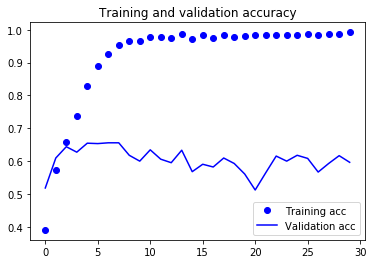

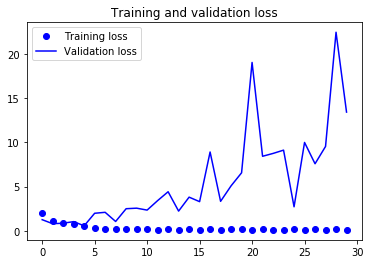

In [18]:
def plot_perf():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [19]:
# predict
y_hat = classifier.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)

# true labels
y_true = test_generator.classes

Report the accuracy as well as the classification report. Use sklearn functions

In [20]:
print('Simple CNN')
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))

Simple CNN
Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.6358381502890174
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       162
           1       0.71      0.75      0.72       228
           2       0.55      0.44      0.49       152
           3       0.61      0.74      0.67       137
           4       0.61      0.66      0.63       186

    accuracy                           0.64       865
   macro avg       0.63      0.63      0.62       865
weighted avg       0.63      0.64      0.63       865



Print the confusion matrix

In [21]:
# the confusion matrix
print(confusion_matrix(y_true, y_hat))

[[ 90  26  12  22  12]
 [ 20 170   7  24   7]
 [ 13  12  67   9  51]
 [  6  19   4 101   7]
 [  9  14  32   9 122]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [22]:
test_loss_1, test_acc_1 = classifier.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_1, test_acc_1

(13.753254890441895, 0.6358381509780884)

In [38]:
# Classifier
def classifier():
    classifier = models.Sequential()

    classifier.add(layers.Conv2D(filters = 32, kernel_size = 5, input_shape = dimensions))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 64, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 96, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.2))

    classifier.add(layers.Conv2D(filters = 128, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.3))
    
    classifier.add(layers.Conv2D(filters = 256, kernel_size = 3 , activation='relu'))
    classifier.add(layers.MaxPooling2D(pool_size = (2, 2)))
    classifier.add(layers.BatchNormalization())
    classifier.add(layers.Dropout(0.3))

    classifier.add(layers.Flatten())

    classifier.add(layers.Dense(units = 256, activation='relu', input_dim= 5*7*128 ))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.BatchNormalization())
    # classifier.add(layers.BatchNormalization())

    classifier.add(layers.Dense(units = 5, activation='softmax'))

    classifier.compile(optimizer = OPTIMIZER, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [39]:
classifier1 = classifier()
classifier1.summary()
history = classifier1.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 235, 311, 32)      2432      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 117, 155, 32)      0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 117, 155, 32)      128       
_________________________________________________________________
dropout_43 (Dropout)         (None, 117, 155, 32)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 115, 153, 64)      18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 57, 76, 64)        0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 57, 76, 64)      

In [44]:
# save the model
classifier1.save('classifier_2.h5')

In [125]:
classifier1 = load_model('classifier_2.h5')

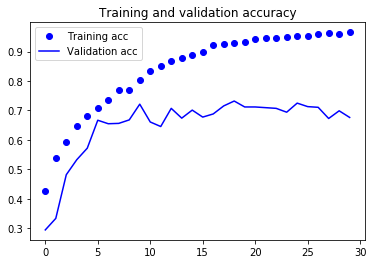

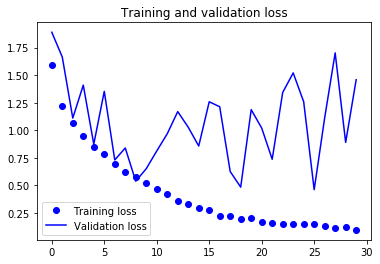

In [40]:
plot_perf()

In [41]:
# predict
y_hat = classifier1.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)

# true labelslab
y_true = test_generator.classes

In [42]:
print('Simple CNN')
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))
print(confusion_matrix(y_true, y_hat))

Simple CNN
Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.7283236994219653
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       162
           1       0.71      0.86      0.78       228
           2       0.68      0.57      0.62       152
           3       0.79      0.76      0.78       137
           4       0.74      0.68      0.71       186

    accuracy                           0.73       865
   macro avg       0.73      0.72      0.72       865
weighted avg       0.73      0.73      0.73       865

[[118  27   5   5   7]
 [ 15 196   3   8   6]
 [ 15  17  86   7  27]
 [  5  18   6 104   4]
 [  7  19  27   7 126]]


In [43]:
test_loss_1, test_acc_1 = classifier1.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_1, test_acc_1

(1.8937839269638062, 0.7283236980438232)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [47]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = 32,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size = 32,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = 32,
        shuffle=False,
        class_mode="categorical")

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit a model. You reset the model by recreating it.

In [48]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size
classifier2 = classifier()
history = classifier2.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)

Epoch 1/30
81/81 [==============================] - 56s 694ms/step - loss: 1.6304 - accuracy: 0.4163 - val_loss: 3.9848 - val_accuracy: 0.2368
Epoch 2/30
81/81 [==============================] - 60s 736ms/step - loss: 1.3346 - accuracy: 0.4865 - val_loss: 2.2465 - val_accuracy: 0.3032
Epoch 3/30
81/81 [==============================] - 57s 704ms/step - loss: 1.1989 - accuracy: 0.5521 - val_loss: 2.0382 - val_accuracy: 0.3418
Epoch 4/30
81/81 [==============================] - 59s 726ms/step - loss: 1.1229 - accuracy: 0.5712 - val_loss: 1.9109 - val_accuracy: 0.4621
Epoch 5/30
81/81 [==============================] - 58s 714ms/step - loss: 1.0406 - accuracy: 0.5993 - val_loss: 1.6160 - val_accuracy: 0.5680
Epoch 6/30
81/81 [==============================] - 58s 715ms/step - loss: 0.9680 - accuracy: 0.6219 - val_loss: 1.8303 - val_accuracy: 0.5150
Epoch 7/30
81/81 [==============================] - 58s 715ms/step - loss: 0.9453 - accuracy: 0.6391 - val_loss: 1.1914 - val_accuracy: 0.6438

In [52]:
# save the model
classifier2.save('classifier_aug.h5')

In [130]:
classifier2 = load_model('classifier_aug.h5')

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

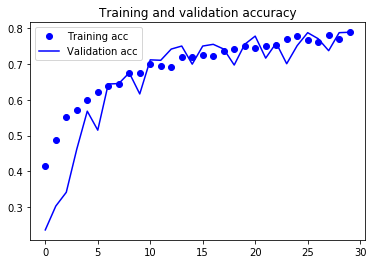

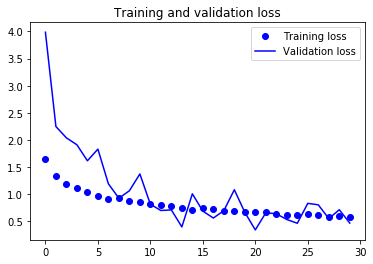

In [49]:
plot_perf()

### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [50]:
# predict
y_hat = classifier2.predict_generator(test_generator, test_generator.n//test_generator.batch_size +1)
y_hat = np.argmax(y_hat, axis=1)
# true labels
y_true = test_generator.classes
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat))
print("Confusion matrix:\n", confusion_matrix(y_true, y_hat))

sklearn accuracy: 0.7838150289017342
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80       162
           1       0.89      0.81      0.85       228
           2       0.69      0.70      0.70       152
           3       0.76      0.88      0.82       137
           4       0.69      0.80      0.74       186

    accuracy                           0.78       865
   macro avg       0.79      0.78      0.78       865
weighted avg       0.79      0.78      0.79       865

Confusion matrix:
 [[117  12  14   6  13]
 [  9 185   3  23   8]
 [  1   3 107   3  38]
 [  3   4   3 121   6]
 [  0   4  28   6 148]]


In [51]:
test_loss_2, test_acc_2 = classifier2.evaluate_generator(test_generator, test_generator.n//test_generator.batch_size +1)
test_loss_2, test_acc_2

(0.8976224064826965, 0.7838150262832642)

## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [53]:
from keras.applications import VGG16, InceptionV3

In [95]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_523 (Conv2D)             (None, 74, 74, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_531 (BatchN (None, 74, 74, 32)   96          conv2d_523[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 74, 74, 32)   0           batch_normalization_531[0][0]    
_______________________________________________________________________________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [139]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
def extract_features(directory, sample_count):
    shuffle = False if directory == test_path else True
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        shuffle= shuffle,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

The features and labels

In [140]:
train_features, train_labels = extract_features(train_path, 2595)
validation_features, validation_labels = extract_features(val_path, 863)
test_features, test_labels = extract_features(test_path, 865)

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [141]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [142]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= np.prod(test_features.shape[1:])))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 1285      
Total params: 4,720,133
Trainable params: 4,720,133
Non-trainable params: 0
_________________________________________________________________


Fit your network

In [143]:

history = model.fit(train_features, train_labels,
                    batch_size = batch_size,
                    epochs=30,
                    validation_data=(validation_features, validation_labels))

Train on 2595 samples, validate on 863 samples
Epoch 1/30
2595/2595 [==============================] - 1s 281us/step - loss: 3.6809 - accuracy: 0.7438 - val_loss: 3.3610 - val_accuracy: 0.7692
Epoch 2/30
2595/2595 [==============================] - 1s 230us/step - loss: 2.6943 - accuracy: 0.8015 - val_loss: 2.3293 - val_accuracy: 0.8257
Epoch 3/30
2595/2595 [==============================] - 1s 245us/step - loss: 2.1671 - accuracy: 0.8334 - val_loss: 1.8257 - val_accuracy: 0.8589
Epoch 4/30
2595/2595 [==============================] - 1s 240us/step - loss: 1.7964 - accuracy: 0.8531 - val_loss: 1.5958 - val_accuracy: 0.8468
Epoch 5/30
2595/2595 [==============================] - 1s 226us/step - loss: 1.2021 - accuracy: 0.8662 - val_loss: 0.4497 - val_accuracy: 0.8660
Epoch 6/30
2595/2595 [==============================] - 1s 227us/step - loss: 0.2998 - accuracy: 0.9044 - val_loss: 0.3015 - val_accuracy: 0.8915
Epoch 7/30
2595/2595 [==============================] - 1s 230us/step - loss:

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [118]:
# save the model
model.save('classifier_pre.h5')

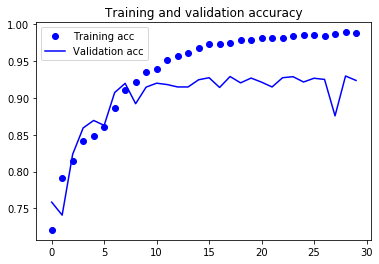

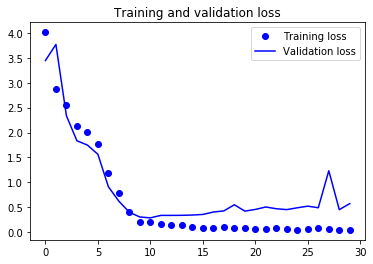

In [119]:
model = load_model('classifier_pre.h5')
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [151]:
test_hat = list(model.predict_classes(test_features))

test_labels_1 = list(np.argmax(test_labels, axis=1))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 3,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 4,
 4,
 0,
 3,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 2,
 0,
 0,
 1,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 4,
 2,
 3,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 0,
 1,
 0,
 1,
 1,


Report the accuracy as well as the classification report. Use sklearn functions

In [152]:
print('Simple CNN')
print("sklearn accuracy:", accuracy_score(test_labels_1, test_hat))
print("Classification report:\n",classification_report(test_labels_1, test_hat))

Simple CNN
sklearn accuracy: 0.791907514450867
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       162
           1       0.96      0.75      0.84       228
           2       0.68      0.82      0.75       152
           3       0.68      0.90      0.77       137
           4       0.81      0.76      0.79       186

    accuracy                           0.79       865
   macro avg       0.79      0.80      0.79       865
weighted avg       0.81      0.79      0.79       865



Print the confusion matrix

In [153]:
print("Confusion matrix:\n", confusion_matrix(test_labels_1, test_hat))

Confusion matrix:
 [[124   6  11  13   8]
 [ 15 171  12  25   5]
 [  4   1 125   8  14]
 [  2   0   6 123   6]
 [  2   1  29  12 142]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [154]:
test_loss_3, test_acc_3 = model.evaluate(test_features,test_labels)
test_loss_3, test_acc_3

865/865 [==============================] - 0s 90us/step


(0.5957221254447981, 0.9179190993309021)

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [162]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_711 (Conv2D)             (None, 74, 74, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_721 (BatchN (None, 74, 74, 32)   96          conv2d_711[0][0]                 
__________________________________________________________________________________________________
activation_659 (Activation)     (None, 74, 74, 32)   0           batch_normalization_721[0][0]    
_______________________________________________________________________________________

In [163]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim= 3*3*2048 ))
model.add(layers.BatchNormalization())

model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_15 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               4718848   
_________________________________________________________________
batch_normalization_815 (Bat (None, 256)               1024      
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 1285      
Total params: 26,523,941
Trainable params: 26,488,997
Non-trainable params: 34,944
_________________________________________________________________


Create the generators

In [164]:
batch = 32
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=10,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.1,
      horizontal_flip=True,
      vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
        train_path, target_size = dimension,
        batch_size = batch,
        class_mode="categorical")

val_generator = val_datagen.flow_from_directory(
        val_path, target_size = dimension,
        batch_size =batch,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, target_size = dimension,
        batch_size = batch,
        shuffle=False,
        class_mode="categorical")

Found 2595 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [165]:
# print('This is the number of trainable weights '
#       'before freezing the conv base:', len(model.trainable_weights))
# conv_base.trainable = False
# print('This is the number of trainable weights '
#       'after freezing the conv base:', len(model.trainable_weights))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Fit the model

In [166]:
STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEPS = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=STEPS_PER_EPOCH,
                                   epochs = EPOCHS,
                                   validation_data = val_generator,
                                   validation_steps = VALIDATION_STEPS)


Epoch 1/30
81/81 [==============================] - 38s 470ms/step - loss: 0.3760 - accuracy: 0.8449 - val_loss: 0.3110 - val_accuracy: 0.8808
Epoch 2/30
81/81 [==============================] - 21s 263ms/step - loss: 0.2440 - accuracy: 0.9001 - val_loss: 0.3029 - val_accuracy: 0.9042
Epoch 3/30
 8/81 [=>............................] - ETA: 17s - loss: 0.2172 - accuracy: 0.9250

KeyboardInterrupt: 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

In [105]:
# save the model
model.save('classifier_pre_aug.h5')

In [167]:
model = load_model('classifier_pre_aug.h5')

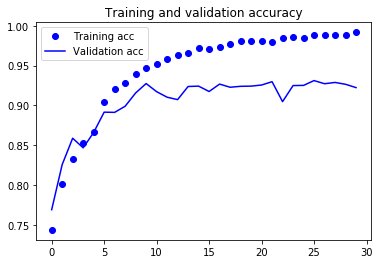

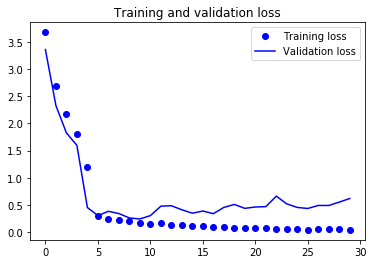

In [168]:
plot_perf()

### Predicting the test set

Apply now your network to the test set

In [185]:
# predict
y_hat = model.predict_generator(test_generator, steps=test_generator.n//test_generator.batch_size +1, verbose=2)
y_hat = y_hat.argmax(1)
# true labels
y_true = test_generator.classes


Report the accuracy as well as the classification report. Use sklearn functions

In [186]:
print("Class indices ", train_generator.class_indices)
print("sklearn accuracy:", accuracy_score(y_true, y_hat))
print("Classification report:\n",classification_report(y_true, y_hat, target_names=train_generator.class_indices.keys()))

Class indices  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.8809248554913295
Classification report:
               precision    recall  f1-score   support

       daisy       0.86      0.85      0.86       162
   dandelion       0.89      0.93      0.91       228
        rose       0.85      0.84      0.85       152
   sunflower       0.91      0.93      0.92       137
       tulip       0.88      0.84      0.86       186

    accuracy                           0.88       865
   macro avg       0.88      0.88      0.88       865
weighted avg       0.88      0.88      0.88       865



Print the confusion matrix

In [187]:
print("Classification report:\n", confusion_matrix(y_true, y_hat))

Classification report:
 [[138   8   5   1  10]
 [ 10 211   4   2   1]
 [  4   4 128   5  11]
 [  3   5   1 128   0]
 [  5   8  12   4 157]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [188]:
test_loss_4, test_acc_4 = model.evaluate_generator(test_generator, steps=test_generator.n//test_generator.batch_size +1)
test_loss_4, test_acc_4

(0.35698193311691284, 0.9537572264671326)

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [162]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((0.42597150802612305, 0.6890173554420471),
 (0.40577325224876404, 0.7861271500587463),
 (0.4943826881687849, 0.957456648349762),
 (0.35698193311691284, 0.9537572264671326))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. 
3. You will run it on one of your images.

You will submit this report through Canvas.